In [633]:
import numpy as np
from math import comb
import itertools
import matplotlib.pyplot as plt

In [634]:
N_CARDS = 5
N_HAND = 2
total_regret = []

In [635]:
def cfr(i_map, history="", p1_cards=[], p2_cards=[], pr1=0, pr2=0, prc=0):
    """
    CounterFactual Regret Minimization Algo

    Params:
    i_map -> dict of all info sets
    history -> a string representation of the game tree path we have taken
               note: every 2 char bundle represents a single action taken
    p1_cards -> list of player 1's cards
    p2_cards -> list of player 2's cards
    pr1 -> the probability that player 1 reaches 'history'
    pr2 -> the probability that player 2 reaches 'history'
    ^ the above two can also be though of as the contribution of each to reach prob
    prc -> the probability contribution of chance events to reach history
    """

    if is_chance_node(history):
        return chance_util(i_map) # fix, may need new params?
    
    if is_terminal_node(history):
        return terminal_util(history) # fix, may need new params?
    
    n = len(history) # starting w 1 char implementation (max 9 card deck), next steps would be to account for 2 char bundles
    is_p1 = n%2 == 0

    infoset = get_infoset(i_map, p1_cards if is_p1 else p2_cards, history)

    strategy = infoset.strategy
    
    if is_p1:
        infoset.reach_pr += pr1
    else:
        infoset.reach_pr += pr2

    if len(history) <= 3:
        #bidding stage
        action_utils = np.zeros(N_HAND+1) # counterfactual util per action (0-2 possible bids)
        for i in range(N_HAND+1):
            next_history = history + str(i)
            if is_p1:
                action_utils[i] = -cfr(i_map, next_history, p1_cards, p2_cards, pr1*strategy[i], pr2, prc)
            else:
                action_utils[i] = -cfr(i_map, next_history, p1_cards, p2_cards, pr1, pr2*strategy[i], prc)
        pass
    else:
        #playing stage
        action_utils = np.zeros(len(p1_cards) if is_p1 else len(p2_cards)) # counterfactual util per action
        for i, play in enumerate(p1_cards if is_p1 else p2_cards):
            next_history = history + str(play)
            if is_p1:
                temp = p1_cards.copy()
                temp.remove(play)
                action_utils[i] = -cfr(i_map, next_history, temp, p2_cards, pr1*strategy[i], pr2, prc)
            else:
                temp = p2_cards.copy()
                temp.remove(play)
                action_utils[i] = -cfr(i_map, next_history, p1_cards, temp, pr1, pr2*strategy[i], prc)
    
    # by infoset, utility
    util = sum(strategy * action_utils)
    regrets = action_utils - util
    if is_p1:
        infoset.regret_sum += pr2 * prc * regrets
    else:
        infoset.regret_sum += pr1 * prc * regrets

    return util

In [636]:
def is_chance_node(history):
    return len(history) == 0 or history == ""

def chance_util(i_map):
    expected_val = 0
    n_possible = comb(N_CARDS, N_HAND) * comb(N_CARDS-N_HAND, N_HAND)
    for hand1 in itertools.combinations(range(N_CARDS), N_HAND):
        for hand2 in itertools.combinations(range(N_CARDS), N_HAND):
            # condition, no overlap in hands
            if len(set(hand1).intersection(set(hand2))) != 0:
                continue
            else: expected_val += cfr(i_map, "dd", list(hand1), list(hand2), 1, 1, 1/n_possible)
    return expected_val/n_possible

In [637]:
def is_terminal_node(history):
    return len(history) == 4 + 2*N_HAND

def terminal_util(history):
    b1 = int(history[3])
    b2 = int(history[4])

    #count tricks won
    w1 = 0
    w2 = 0
    for c in range(4, len(history), 2):
        if int(history[c]) > int(history[c+1]):
            w1 += 1
        else:
            w2 += 1
    i = abs(b1-w1)
    j = abs(b2-w2)
    
    return i-j

    '''
    for i in range(2, len(history), 2):
        return int(int(history[i]) > int(history[i+1])) # fix for bidded version
    '''

In [638]:
def get_infoset(i_map, cards, history):
    str_cards = [str(card) for card in cards]
    key = ''.join(sorted(str_cards)) + " " + history
    infoset = None
    if key not in i_map:
        infoset = InformationSet(key)
        i_map[key] = infoset
        return infoset
    else:
        return i_map[key]

In [639]:
class InformationSet():
    def __init__(self, key):
        self.key = key
        if len(key.split()[1]) <= 3:
            #bidding stage
            self.id = 'bidding'
            self.regret_sum = np.zeros(N_HAND+1)
            self.strategy_sum = np.zeros(N_HAND+1)
            self.strategy = np.repeat(1/(N_HAND+1), N_HAND+1)
        else:
            #playing stage
            self.id = 'playing'
            self.regret_sum = np.zeros(len(key.split()[0]))
            self.strategy_sum = np.zeros(len(key.split()[0]))
            self.strategy = np.repeat(1/len(key.split()[0]), len(key.split()[0]))
        self.reach_pr = 0
        self.reach_pr_sum = 0

    def next_strategy(self):
        self.strategy_sum += self.reach_pr * self.strategy
        self.strategy = self.calc_strategy()
        self.reach_pr_sum += self.reach_pr
        self.reach_pr = 0

    def calc_strategy(self):
        strategy = self.make_positive(self.regret_sum)
        total = sum(strategy)
        if total > 0:
            strategy /= total
        else:
            if self.id == 'bidding':
                n = N_HAND + 1
            else:
                n = len(self.key.split()[0])
            strategy = np.repeat(1/n, n)
        return strategy

    def get_average_strategy(self):
        ## finding the Nash Equilibrium strat based on iterations
        strategy = self.strategy_sum / self.reach_pr_sum
        strategy = np.where(strategy < 0.001, 0, strategy)
        total = sum(strategy)
        strategy /= total
        return strategy
    
    def make_positive(self, x):
        return np.where(x > 0, x, 0)
    
    def __str__(self):
        return self.key + " " + str(self.get_average_strategy())

In [640]:
def display(ev, i_map):
    print("Expected Value for P1: ", ev)
    print("Expected Value for P2: ", -1 * ev)
    print()
    print('P1 strategies:')
    p1_items = sorted(i_map.items(), key=lambda x: x[0])
    for i,j in filter(lambda x: len(x[0].split()[1]) % 2 == 0 and len(x[0].split()[1]) > 1, p1_items):
        print(j)
    print()
    print('P2 strategies:')
    p2_items = sorted(i_map.items(), key=lambda x: x[0])
    for i,j in filter(lambda x: len(x[0].split()[1]) % 2 == 1 and len(x[0].split()[1]) > 1, p2_items):
        print(j)

In [641]:
#run cfr iterations
def main():
    i_map = {} # map of infosets
    n_iter = 1000
    expected_game_val = 0

    for _ in range(n_iter):
        expected_game_val += cfr(i_map)
        subregret = 0
        for _, v in i_map.items(): 
            v.next_strategy()
            subregret += np.sum(v.regret_sum)
        #regret per iteration
        total_regret.append(subregret)
    
    expected_game_val /= n_iter

    #plot total regret
    plt.plot(np.diff(np.log(np.absolute(total_regret)))[1:])
    # make y axis log scale
    plt.yscale('log')
    plt.xlabel('Iterations')
    plt.ylabel('Epsilon')
    #title specifies N_CARDS, N_HAND
    plt.title('Regret Sum by CFR Iteration (Log Scale):' + ' n= ' + str(N_CARDS) + ' k= ' + str(N_HAND), fontsize=10)
    plt.show()

    display(expected_game_val, i_map)

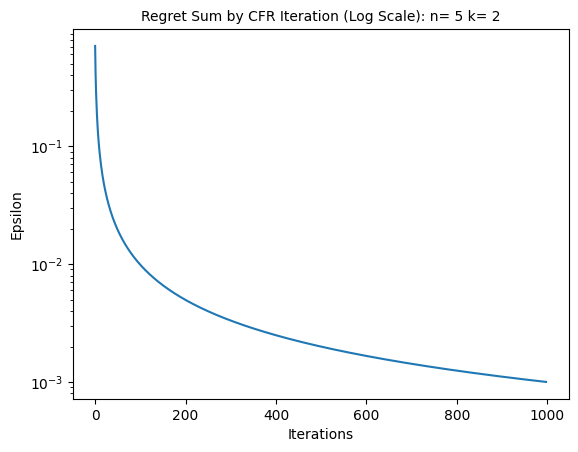

Expected Value for P1:  -0.9998651753618114
Expected Value for P2:  0.9998651753618114

P1 strategies:
0 dd0012 [1.]
0 dd0013 [1.]
0 dd0014 [1.]
0 dd0021 [1.]
0 dd0023 [1.]
0 dd0024 [1.]
0 dd0031 [1.]
0 dd0032 [1.]
0 dd0034 [1.]
0 dd0041 [1.]
0 dd0042 [1.]
0 dd0043 [1.]
0 dd0112 [1.]
0 dd0113 [1.]
0 dd0114 [1.]
0 dd0121 [1.]
0 dd0123 [1.]
0 dd0124 [1.]
0 dd0131 [1.]
0 dd0132 [1.]
0 dd0134 [1.]
0 dd0141 [1.]
0 dd0142 [1.]
0 dd0143 [1.]
0 dd0212 [1.]
0 dd0213 [1.]
0 dd0214 [1.]
0 dd0221 [1.]
0 dd0223 [1.]
0 dd0224 [1.]
0 dd0231 [1.]
0 dd0232 [1.]
0 dd0234 [1.]
0 dd0241 [1.]
0 dd0242 [1.]
0 dd0243 [1.]
0 dd1012 [1.]
0 dd1013 [1.]
0 dd1014 [1.]
0 dd1021 [1.]
0 dd1023 [1.]
0 dd1024 [1.]
0 dd1031 [1.]
0 dd1032 [1.]
0 dd1034 [1.]
0 dd1041 [1.]
0 dd1042 [1.]
0 dd1043 [1.]
0 dd1112 [1.]
0 dd1113 [1.]
0 dd1114 [1.]
0 dd1121 [1.]
0 dd1123 [1.]
0 dd1124 [1.]
0 dd1131 [1.]
0 dd1132 [1.]
0 dd1134 [1.]
0 dd1141 [1.]
0 dd1142 [1.]
0 dd1143 [1.]
0 dd1212 [1.]
0 dd1213 [1.]
0 dd1214 [1.]
0 dd1221 [1.]
0

In [642]:
main()